# Trace Genomics Data Science Test

## General approach
- 1 I clean up the data and remove messy OTU taxonomy reporting. 
- 2 I only look at samples from conventional farming.
- 3 We look at a histogram of the yields. 
- 4 We perform PCA across the OTU axis to try and elucidate some trends.
- 5 Produce an SVM for predicting healthy/not healthy.
- 6 Produce a linear regressor for predicting yield. 

### Usage
This notebook should run in python2 given the imports below.
*Michael Wiest 12/19/18*



In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA
from scipy.stats.mstats import gmean, zscore
from sklearn import svm
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
# Function for performing centered log ratio. 
def clr(some_array, axis):
    gms = gmean(some_array, axis=axis)
    gms = np.expand_dims(gms, axis=axis)
    gms = np.repeat(gms, some_array.shape[axis], axis=axis)
    return np.log(some_array / gms)



In [3]:
tax_file = 'data_challenge-otu_hits.csv'
meta_file = 'data_challenge-metadata.csv'

In [4]:
# Percent threshold below which to ignore values.
# Reduces the number of features to the model.
threshold = 0.05
# With this flag we try and ignore some taxonomic data. This could be resolved if much of the input data were cleaner.
# Ie, there is species info but no genus info for many samples. 
filter_taxonomy = True

In [5]:
tax_df = pd.read_csv(tax_file, header=0, index_col=0)

tax_df = tax_df[(tax_df.values > threshold).any(1)]

if filter_taxonomy: 
    '''
    Here we try and clean up the taxonomic data. In general 16s sequencing for species is pretty unreliable. 
    Here I'm trying to group redundant OTUs together. Also there are many OTUs with missing kingdom data. Ideally
    this should be present for all of them, but I am stripping it to collapse more strains together.
    '''
    tax_raw = tax_df.index.values
    split_tax = [tr.split(';') for tr in tax_raw]

    output = []
    for sample in split_tax:
        new_samp = []
        for tax in sample:
            if not (tax.startswith('no rank') or
                    tax.startswith('sub') or
                    tax.startswith('super') or
                    tax.startswith('kingdom') 
                    or tax.startswith('species')
                   ):
                new_samp.append(tax)
        output.append(new_samp)
    new_index = [';'.join(o) for o in output]
    tax_df.index = new_index
    tax_df = tax_df[tax_df.index != '']
    tax_df = tax_df.groupby(tax_df.index).sum()


In [6]:
# Read in the metadata file. 
meta_df = pd.read_csv(meta_file, header=0, index_col=0)

In [7]:
# Only keep rows where the production type is conventional. 
meta_df = meta_df[meta_df.production_type == 'conventional']

# Extract the field number for the sample. This isn't really implemented, but could be in
# the future for more fine-grained comparison.
meta_df['field_number'] = [int(str(mf[:3])) for mf in meta_df['subfield_name'].str.extract('field (\d\d\d.?)')]

# Subset the taxonomy data in accordance with the metadata subset.
tax_df = tax_df.iloc[:, :meta_df.shape[0]]


# Assign the healthy/not healthy binary label.
meta_df['not_healthy'] = meta_df.subfield_name.str.contains('not healthy')
meta_df = meta_df.rename(columns={meta_df.columns[-3]: "yield" })
print(meta_df.columns)


Index([u'sampling_date', u'soil_depth', u'land_performance', u'current_crop',
       u'previous_crop', u'production_type', u'extraction_date',
       u'subfield_name', u'planting_date', u'yield', u'field_number',
       u'not_healthy'],
      dtype='object')


/Users/michaelwiest/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


# Look at rough breakdown of yield by healthy/not healthy
There is a clear distinction with no unhealthy fields achieveing yields over 800 heads/acre

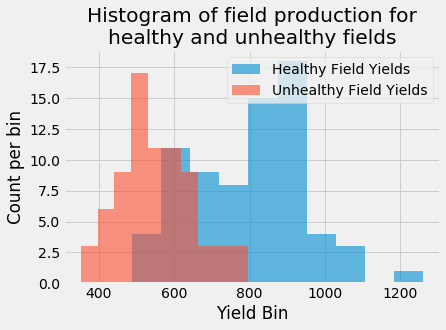

In [8]:
nbins = 10
plt.hist(meta_df[meta_df.not_healthy == False]['yield'].values, 
         bins=nbins, 
         alpha=0.6, 
         label='Healthy Field Yields')
plt.hist(meta_df[meta_df.not_healthy == True]['yield'].values, 
         bins=nbins, 
         alpha=0.6, 
         label='Unhealthy Field Yields')

plt.legend(loc='upper right')
plt.xlabel('Yield Bin')

plt.ylabel('Count per bin')
plt.title('Histogram of field production for\nhealthy and unhealthy fields')
plt.show()

# Get OTU log fold change across healthy / unhealthy
In general this did not yield any real insight but it is a decent first step in the analysis.

In [9]:
not_healthy_indices = meta_df['not_healthy'].values

# This was originally going to be for subsetting the data based on the incoming field.
# But I didnt' get around to it. 
# which_fields = (meta_df['field_number'] == 556).values
which_fields = [True] * meta_df.shape[0]


tax_nh = tax_df.iloc[:, (not_healthy_indices & which_fields)]
tax_h = tax_df.iloc[:, (np.invert(not_healthy_indices) & which_fields)]
print(tax_nh.shape, tax_h.shape)
avg_h = tax_h.mean(axis=1)
avg_nh = tax_nh.mean(axis=1)
print(avg_h.shape)

((527, 75), (527, 73))
(527,)


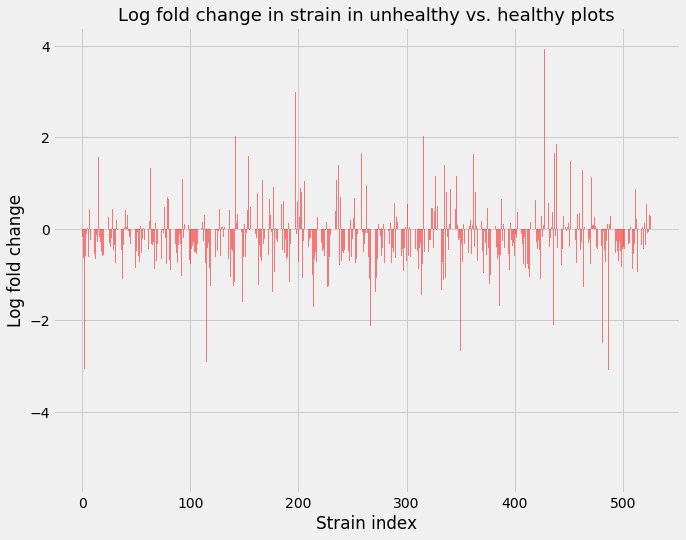

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.750
rects1 = ax.bar(range(len(avg_h)), np.log(avg_nh / avg_h), bar_width, color='red', alpha=0.5)
plt.xlabel('Strain index')
plt.ylabel('Log fold change')
plt.title('Log fold change in strain in unhealthy vs. healthy plots', fontsize=18)
plt.show()

# Perform PCA on inputs across strain axis 
Try and see any clear separability. 

In [11]:
# Helpful coloring
color_lookup = {0: 'blue', 1: 'red'}

In [12]:
# Now we perform PCA on the strains to get an idea of what's going on here. 
tax_vals = tax_df.values
pca = PCA(n_components=2)
pca.fit(tax_vals.T)
transformed = pca.transform(tax_vals.T)
print(transformed.shape)
print(pca.explained_variance_ratio_)

(148, 2)
[ 0.49722253  0.14381472]


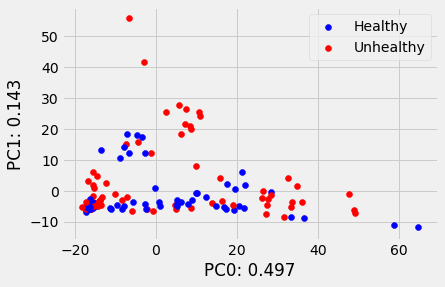

In [13]:


for i in range(meta_df.shape[0]):
    plt.scatter(transformed[i, 0], transformed[i, 1], 
                color=color_lookup[int(meta_df.not_healthy.values[i])])
plt.xlabel('PC0: {}'.format(str(pca.explained_variance_ratio_[0])[:5]))
plt.ylabel('PC1: {}'.format(str(pca.explained_variance_ratio_[1])[:5]))
plt.scatter([], [], color='blue', label='Healthy')
plt.scatter([], [], color='red', label='Unhealthy')
plt.legend(loc='upper right')
plt.show()

# Same thing as above but now we take the CLR of the data. 
This generates more separation and more explained variance, but no clear trend.

In [14]:
# Add some buffer values so we don't get zeroes everywhere.
tax_clr = clr(tax_df + 0.01, axis=1)
# Now we perform PCA on the strains to get an idea of what's going on here. 
tax_vals = tax_clr.values
pca = PCA(n_components=2)
pca.fit(tax_vals.T)
transformed = pca.transform(tax_vals.T)


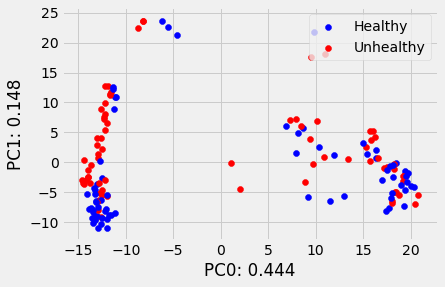

In [15]:

for i in range(meta_df.shape[0]):
    plt.scatter(transformed[i, 0], transformed[i, 1], 
                color=color_lookup[int(meta_df.not_healthy.values[i])]
#                 color=meta_df['yield'].values[i] / meta_df['yield'].sum()
               )
plt.xlabel('PC0: {}'.format(str(pca.explained_variance_ratio_[0])[:5]))
plt.ylabel('PC1: {}'.format(str(pca.explained_variance_ratio_[1])[:5]))
plt.scatter([], [], color='blue', label='Healthy')
plt.scatter([], [], color='red', label='Unhealthy')
plt.legend(loc='upper right')
plt.show()

# Train an SVM on CLR data
This is almost the simplest possible model to use. It is not incorporating any other pertinent metadata and only uses the CLR'd OTU assignments

In [16]:

# Only train the model on the first %80 of the data.
fraction = 0.80
num_cross_validation = 100
accuracies = []

for j in range(num_cross_validation):
    clf = svm.SVC(kernel='linear')
    train_indices = np.random.choice(tax_clr.shape[1], size=int(fraction * tax_clr.shape[1]), replace=False)
    data_sub = tax_clr.T.iloc[train_indices].values[:, :]
    target_sub = meta_df.iloc[train_indices]['not_healthy'].values.astype(int)
    clf.fit(data_sub, target_sub)

    m = 0
    mm = 0
    for i in range(meta_df.shape[0]):
        if i not in train_indices:
            pred = clf.predict(tax_clr.values.T[i, :].reshape(1, -1)).tolist()[0]
            actual = int(meta_df['not_healthy'][i])
            m += int(pred == actual)
            mm += int(pred != actual)
    accuracies.append(100.0 * m / (m + mm))

In [17]:
print('Average accuracy is: {}'.format(np.array(accuracies).mean()))

Average accuracy is: 93.3666666667


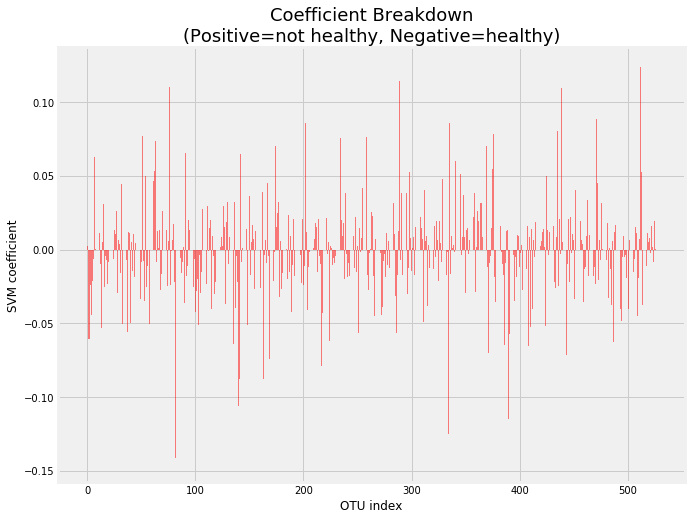

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8))

coeffs = clf.coef_[0].tolist()
rects1 = ax.bar(range(len(coeffs)), coeffs, bar_width, color='red', alpha=0.5)
plt.xlabel('OTU index')
plt.ylabel('SVM coefficient')
plt.title('Coefficient Breakdown\n(Positive=not healthy, Negative=healthy)', fontsize=18)
plt.show()

In [19]:
# Get the top contributing positive and negative strains.
top_neg = np.argsort(coeffs)[-5:].tolist()
top_neg.reverse()
top_pos = np.argsort(coeffs)[:5].tolist()
neg_labels = ([tax_df.index[i] for i in top_neg])
pos_labels = ([tax_df.index[i] for i in top_pos])
print('The top five strains contributing to a healthy field are:\n\t{}'.format('\n\t'.join(pos_labels)))
print('\n\n')
print('The top five strains contributing to an unhealthy field are:\n\t{}'.format('\n\t'.join(neg_labels)))

The top five strains contributing to a healthy field are:
	genus__Idiomarina;family__Idiomarinaceae;order__Alteromonadales;class__Gammaproteobacteria;phylum__Proteobacteria
	genus__Agromyces;family__Microbacteriaceae;order__Micrococcales;class__Actinobacteria;phylum__Actinobacteria
	genus__Pantoea;family__Erwiniaceae;order__Enterobacterales;class__Gammaproteobacteria;phylum__Proteobacteria
	genus__Rhizophagus;family__Glomeraceae;order__Glomerales;class__Glomeromycetes;phylum__Mucoromycota
	genus__Cellulomonas;family__Cellulomonadaceae;order__Micrococcales;class__Actinobacteria;phylum__Actinobacteria



The top five strains contributing to an unhealthy field are:
	phylum__Ascomycota
	genus__Methylobacillus;family__Methylophilaceae;order__Methylophilales;class__Betaproteobacteria;phylum__Proteobacteria
	genus__Aeromonas;family__Aeromonadaceae;order__Aeromonadales;class__Gammaproteobacteria;phylum__Proteobacteria
	genus__Stenotrophomonas;family__Xanthomonadaceae;order__Xanthomonadales;cla

# Linear regression
Try to construct a linear regressor to predict plot yield based on composition of the soil. Not terribly succesful (see discussion below)

/Users/michaelwiest/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


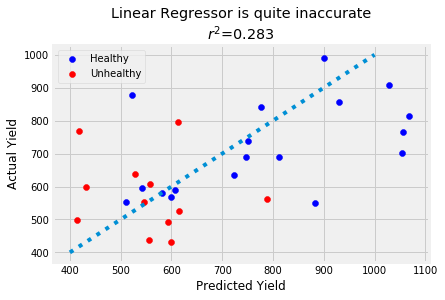

In [20]:
fraction = 0.80

train_indices = np.random.choice(tax_clr.shape[1], size=int(fraction * tax_clr.shape[1]), replace=False)
data_sub = tax_clr.T.iloc[train_indices].values[:, :]
target_sub = meta_df.iloc[train_indices]['yield'].values.astype(float)

reg = LinearRegression().fit(data_sub, target_sub)
preds = []
actuals = []
for i in range(0, meta_df.shape[0]):
    if i not in train_indices:
        pred = reg.predict(tax_clr.values.T[i, :].reshape(1, -1)).tolist()[0]
        actual = int(meta_df['yield'][i])
        plt.scatter(pred, actual, color=color_lookup[meta_df['not_healthy'][i].astype(int)])
#         print(color_lookup[meta_df['not_healthy'][i]],meta_df['not_healthy'][i].astype(int),meta_df['not_healthy'][i],  actual)
        preds.append(pred)
        actuals.append(actual)
plt.scatter([], [], color='blue', label='Healthy')
plt.scatter([], [], color='red', label='Unhealthy')
slope, intercept, r_value, p_value, std_err = stats.linregress(preds, actuals)
plt.plot([400, 1000], [400, 1000], ls=':')
plt.xlabel('Predicted Yield')
plt.ylabel('Actual Yield')
plt.title('Linear Regressor is quite inaccurate\n$r^2$={}'.format(str(r_value**2)[:5]))
plt.legend(loc='upper left')
plt.show()

# Discussion
I focused much of my time on predicting healthy/unhealthy fields as opposed to strictly looking at differences in yield. Indirectly by identifying which strains lead to unhealthy fields we have determined which strains lead to a decreased crop yield. 

## Validity of taxonomy filtering
I decided to filter the taxonomy of the input because there were many instances of lower taxonomic specifications (species, etc.) without higher order (kingdom) specifications. This made me less confident in the output of the model and also it made it harder to interpret. 

Moreover, imperically the SVM achieved better results after filtering the input taxonomy. 

I could have completed the taxonomic tree to fix the issue of missing kingdoms etc. But I did not think this was worth my time in the 4 hours.

## Validitiy of CLR
Using the CLR made the data more separable when performing PCA and resulted in better accuracy with the model. 

Also, given that the microbiome is a compositional system CLR is the de-facto method for data normalization when analyzing microbiome data. 

Also, it gave empirically better results with the SVM (~93% accuracy vs. 76%).
## SVM output analysis
After having utilized the SVM on both filtered (ie, cleaning up taxonomic data) and unfiltered inputs, in both instances the primary contributor to the prediction of being an unhealthy field is the **family__Alcaligenaceae**

For strains contributing to a healthy field, there was less of a clear-cut distinction. More accurate recording of which were the health-inducing strains across different cross-validation experiments will be necessary (the current plot only displays the last output).

## Linear Regression output analysis
In general the linear regressor was not particularly succesful in predicting the yield of a given plot. I believe that the main improvement would be to feed the label of healthy/not healthy to the linear regressor. This is the clearest indicator of yield (as can be seen from the histogram above). 

Next, another feature to feed to the model is the categorical feature of the field number. Certain fields likely are more productive than others and this would clearly help the model in its prediction. 

This would be quite simple given that we already have a (quite accurate) classifier trained and can simply feed the output of that to the linear regressor.

## PCA analysis
Clearly given the output of the CLR PCA plot there are two distinct subgroups present in our populations. Interestingly, those do not correspond to the healthy/unhealthy split. Determining what leads to these distinct clusters is an interesting area for further research.

## Next steps
Some obvious next steps are to:
- Clean up yield data. From the histogram above there is a pretty clear shoulder to the left of the healthy data histogram. That is to say the data is not quite bimodal but it does not follow a clean Gaussian distribution. Cleaning up and normalizing the data to mitigate that effect would be desirable. 
- Normalize the yield data by the field in some way. For instance, certain fields regardless of whether or not they are healthy are likely better producers than others. Field information could also be passed to each of the models as a categorical feature.
- More robust modeling. As mentioned above, these are the simplest possible models that can be implemented. Moving toward deep learning is also another attractive option. That being said, given the small N of this project (<150 rows of data) that is likely not possible with this toy dataset. 